In [1]:
from astropy.io import fits
import Transmission_calculation as trans
from astropy import units as u
import numpy as np
import math
from astropy.modeling.functional_models import Disk2D
from astropy.modeling.models import Gaussian2D
from astropy.modeling.models import Moffat2D
import matplotlib.pyplot as plt
from astropy.io import fits

#change from FWHM to half-light radii

In [2]:
def half_data(data,times):
    newdata=data
    for i in range(0,times):
        new_bound=int(len(data)/2)
        newdata=np.zeros((new_bound,new_bound)) 
        for i in range(0,new_bound):
            for o in range(0,new_bound):
                newdata[i][o]=np.sum(data[i*2:i*2+2,o*2:o*2+2])
        data=newdata        
    print("Compressed {} times".format(times))
    scale=file[0].header['scale']
    new_scale=scale*2**times
    print("Scale now {:2f} arcsec/pixel".format(new_scale))

    return newdata,new_scale

def numerical_durham(diameter,wavelength,shift):
    file=fits.open("PSFs/GLAO_Median_{}nm.fits".format(wavelength))
    data=file['PRIMARY'].data[25]
    scale=file[0].header['scale']
    
    total=sum(sum(data))
    boundary=len(data)

    x = np.arange(0, boundary)
    y = np.arange(0, boundary)
    x, y = np.meshgrid(x, y)

    Disk=Disk2D(1,boundary/2,boundary/2,diameter.value/2/scale)
    Disk_data=Disk(x,y)

    convolved_data=data*Disk_data
    trans=sum(sum(convolved_data))/total
    
    return trans
        

def SNRs(diameters,FWHM=0,wavelength=0,method="analytical"):
    if method=="analytical":
        SNR_vals=trans.analytical_gaussian(diameters*u.arcsec,FWHM*u.arcsec,0*u.arcsec,k_lim=100)/diameters
    if method=="moffat":
        SNR_vals=[]
        for diameter in diameters:
            SNR_vals.append(trans.numerical_moffat(diameter*u.arcsec,FWHM*u.arcsec,0*u.arcsec,beta=2.5,scale=0.01)/diameter)
    if method=="gaussian":
        SNR_vals=[]
        for diameter in diameters:
            SNR_vals.append(trans.numerical_gaussian(diameter*u.arcsec,FWHM*u.arcsec,0*u.arcsec,scale=0.01)/diameter)
    if method=="durham":
        SNR_vals=[]
        for diameter in diameters:
            SNR_vals.append(numerical_durham(diameter,wavelength,0)/diameter)
    return SNR_vals


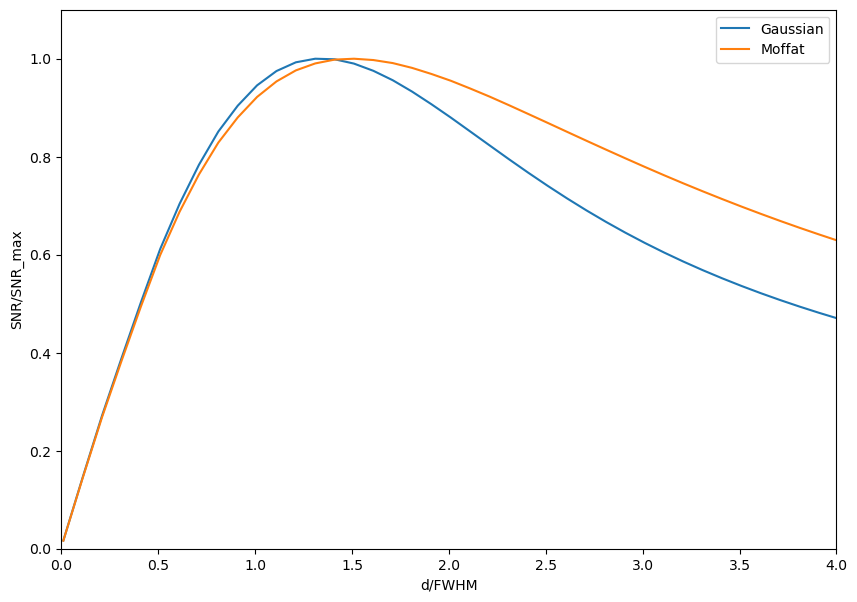

In [3]:
d=np.arange(0.01,4.1,.1)
FWHM=1
anal_vals=SNRs(d,FWHM,method="analytical")
gaus_vals=SNRs(d,FWHM,method="gaussian")
moff_vals=SNRs(d,FWHM,method="moffat")

plt.figure(figsize=[10,7])
plt.plot(d/FWHM,gaus_vals/max(gaus_vals),label="Gaussian")
plt.plot(d/FWHM,moff_vals/max(moff_vals),label="Moffat")
plt.ylabel("SNR/SNR_max")
plt.xlabel("d/FWHM")

plt.xlim(0,4)
plt.ylim(0,1.1)
plt.legend()

0.00148616576923077
Dimensions are 1.52x1.52 arcsecs


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                 1024                                                  
NAXIS2  =                 1024                                                  
NAXIS3  =                   49                                                  
SCALE   =  0.00148616576923077 / Arcsec/pixel                                   

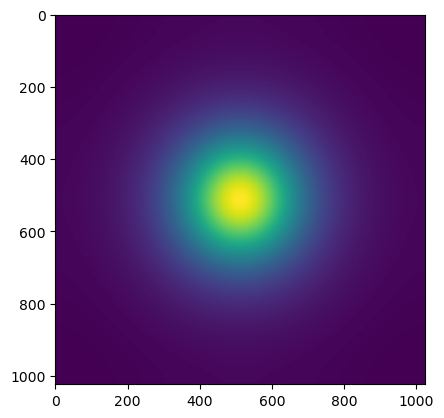

In [4]:
from astropy.io import fits
file=fits.open("PSFs/GLAO_Median_562nm.fits")
file['PRIMARY'].header
plt.imshow(file['PRIMARY'].data[25])
scale=file[0].header['scale']
print(scale)
data=file['PRIMARY'].data[25]
scale=file[0].header['scale']
print("Dimensions are {:2.2f}x{:2.2f} arcsecs".format(len(data)*scale,len(data)*scale))

file[0].header


0.4990275129215254
0.4280157415384618


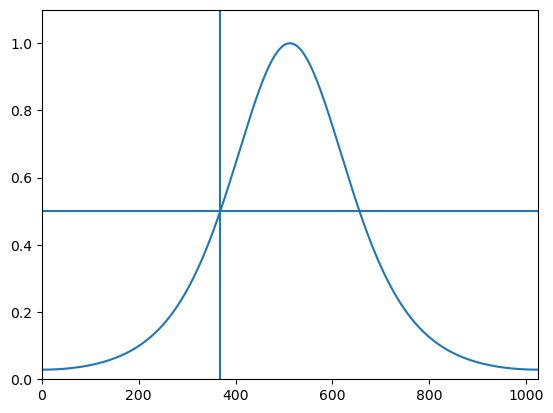

In [5]:
print(data[int(len(data)/2)][368]/data[int(len(data)/2)][int(len(data)/2)])
FWHM=(512-368)*scale*2
print(FWHM)
x=np.arange(0,1024)
plt.plot(x,data[512]/max(data[512]))
plt.axhline(0.5)
plt.xlim(0,1024)
plt.ylim(0,1.1)
plt.axvline(368)

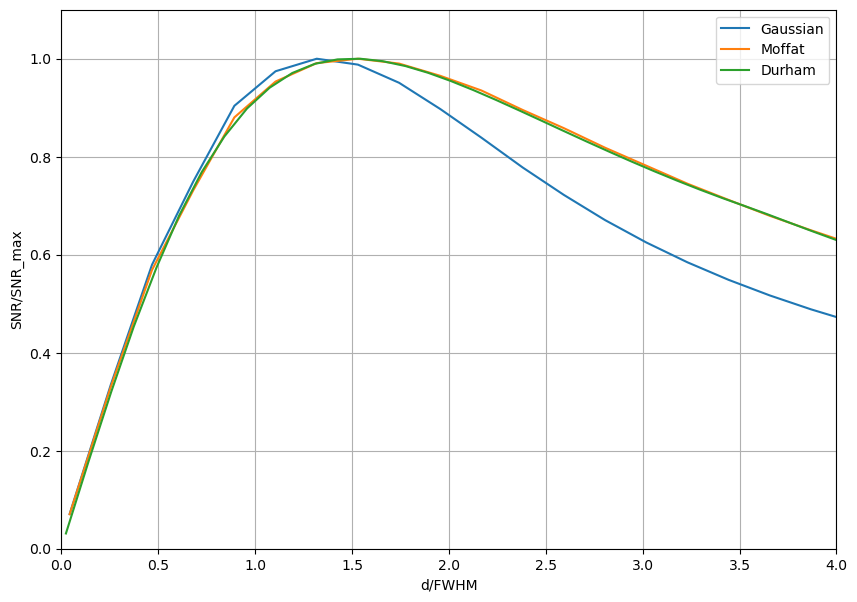

In [14]:
d=np.arange(0.01,4.1,.05)
anal_vals=SNRs(d,FWHM,method="analytical")
gaus_vals=SNRs(d,FWHM,method="gaussian")
moff_vals=SNRs(d,FWHM,method="moffat")

plt.figure(figsize=[10,7])
plt.plot(d/FWHM,gaus_vals/max(gaus_vals),label="Gaussian")
plt.plot(d/FWHM,moff_vals/max(moff_vals),label="Moffat")
plt.ylabel("SNR/SNR_max")
plt.xlabel("d/FWHM")

plt.xlim(0,4)
plt.ylim(0,1.1)
SNR_vals=[]
for diameter in d:
    SNR_vals.append(numerical_durham(diameter*u.arcsec,562,0*u.arcsec)/diameter)
plt.plot(d/0.428,SNR_vals/max(SNR_vals),label="Durham")
plt.legend()
plt.grid()


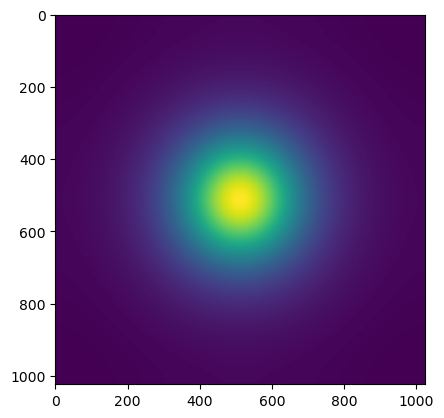

In [7]:

boundary=len(data)

x = np.arange(0, boundary)
y = np.arange(0, boundary)
x, y = np.meshgrid(x, y)

plt.imshow(data)

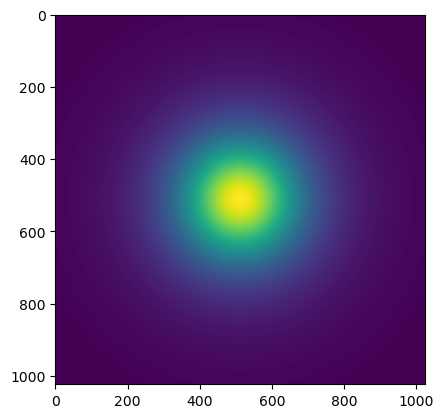

In [8]:
beta=2.5
alpha=FWHM/scale/(2*np.sqrt(2**(1/beta)-1))

b2=512

x = np.arange(-b2, b2)
y = np.arange(-b2, b2)
x, y = np.meshgrid(x, y)


Moffat=Moffat2D(1,0,0,alpha,beta)
Moffat_data=Moffat(x,y)
moffat_total=(np.pi*alpha**2)/(beta-1)

plt.imshow(Moffat_data/moffat_total)

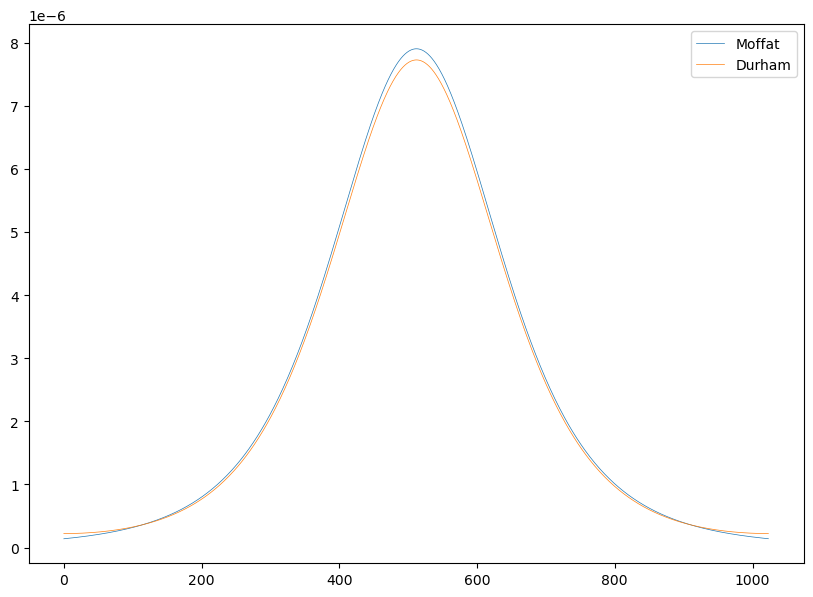

In [9]:
plt.figure(figsize=[10,7])
plt.plot(Moffat_data[512]/sum(sum(Moffat_data)),label='Moffat',linewidth=0.5)
plt.plot(data[512]/(sum(sum(data))),label='Durham',linewidth=0.5)
#plt.xlim(-500,500)
#plt.ylim(0,1.1)
plt.legend()

In [10]:
print(sum(sum(data)))
print(sum(sum(Moffat_data)))

0.9999999999999994
126507.1016528444


0.003178596538461538
Dimensions are 3.25x3.25 arcsecs


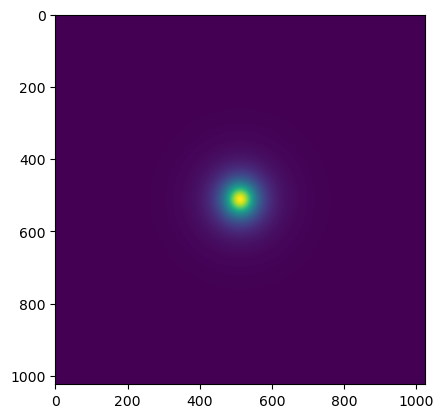

In [11]:
from astropy.io import fits
file=fits.open("PSFs/GLAO_Median_1202nm.fits")
file['PRIMARY'].header
plt.imshow(file['PRIMARY'].data[25])
scale=file[0].header['scale']
print(scale)
data=file['PRIMARY'].data[25]
scale=file[0].header['scale']
print("Dimensions are {:2.2f}x{:2.2f} arcsecs".format(len(data)*scale,len(data)*scale))


0.49785532402835203
0.2352161438461538


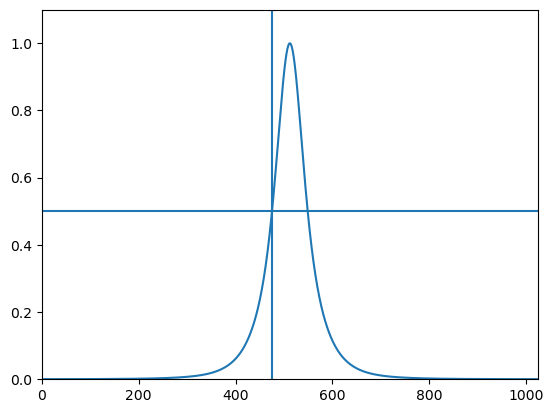

In [12]:
print(data[int(len(data)/2)][475]/data[int(len(data)/2)][int(len(data)/2)])
FWHM=(512-475)*scale*2
print(FWHM)
x=np.arange(0,1024)
plt.plot(x,data[512]/max(data[512]))
plt.axhline(0.5)
plt.xlim(0,1024)
plt.ylim(0,1.1)
plt.axvline(475)

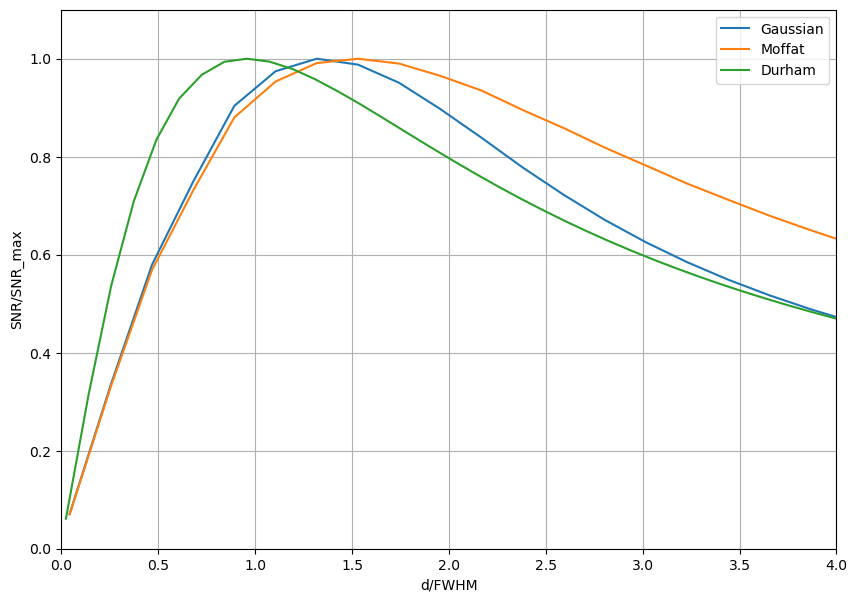

In [13]:
d=np.arange(0.01,4.1,.05)
anal_vals=SNRs(d,FWHM,method="analytical")
gaus_vals=SNRs(d,FWHM,method="gaussian")
moff_vals=SNRs(d,FWHM,method="moffat")

plt.figure(figsize=[10,7])
plt.plot(d/FWHM,gaus_vals/max(gaus_vals),label="Gaussian")
plt.plot(d/FWHM,moff_vals/max(moff_vals),label="Moffat")
plt.ylabel("SNR/SNR_max")
plt.xlabel("d/FWHM")
plt.grid()
plt.xlim(0,4)
plt.ylim(0,1.1)
SNR_vals=[]
for diameter in d:
    SNR_vals.append(numerical_durham(diameter*u.arcsec,1202,0*u.arcsec)/diameter)
plt.plot(d/0.428,SNR_vals/max(SNR_vals),label="Durham")
plt.legend()


0.529691961732407


0.4996499620080114


0.6488388420691502
